# Showcase of the "to_sql" functionality of mlinspect

It will be shown how parts of the original mlinspect example pipelines
"healthcare" and "compas" will be inspected using the additional "to_sql"
functionality.

## First install the required packages

In [1]:
# Install the pip packages in the current Jupyter kernel
import pathlib
import sys
!{sys.executable} -m pip install faker

## Some parameters you might want to set:#

In [2]:
from inspect import cleandoc
import matplotlib.pyplot as plt

from mlinspect.to_sql.dbms_connectors.postgresql_connector import PostgresqlConnector
from mlinspect.to_sql.dbms_connectors.umbra_connector import UmbraConnector
from pandas_connector import PandasConnector
from mlinspect import PipelineInspector

from pandas_connector import PandasConnector
from _benchmark_utility import plot_compare, ROOT_DIR, PLOT_DIR
from _code_as_string import Join, GroupBy, Selection, Projection


UMBRA_DIR = r"/home/luca/Documents/Bachelorarbeit/umbra-students"
DO_CLEANUP = True
SIZES = [(10 ** i) for i in range(2, 5, 1)]
BENCH_REP = 10

# Data Generation

To be able to benchmark and compare the different approaches, some datasets
will need to be generated before. The datasets are just and expansion of the
original ones.

In [3]:
from data_generation._compas_data_generation import generate_compas_dataset
from data_generation._healthcare_data_generation import generate_healthcare_dataset

# compas_tain, compas_test \
COMPAS_DATA_PATHS = generate_compas_dataset(SIZES)
# healthcare_histories, healthcare_patients \
HEALTHCARE_DATA_PATHS = generate_healthcare_dataset(SIZES)

Data generated or found for: size = 100 -- compas
Data generated or found for: size = 1000 -- compas
Data generated or found for: size = 10000 -- compas
Data generated or found for: size = 100 -- healthcare
Data generated or found for: size = 1000 -- healthcare
Data generated or found for: size = 10000 -- healthcare


## Benchmark simple operations (not exhaustive)

No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


ITERATION: 0 - for table size of: 100
Executing Query in Umbra...
Done in 0.00024010000000000004!
Executing Query in Postgres...
Done in 0.7606!
Executing Query in Pandas...
Done in 6.436101500003133!
Executing Query in Umbra...
Done in 0.00011879999999999999!
Executing Query in Postgres...
Done in 0.16779999999999998!
Executing Query in Pandas...
Done in 2.9921291999926325!
Executing Query in Umbra...
Done in 0.0002501!
Executing Query in Postgres...
Done in 0.3201!
Executing Query in Pandas...
Done in 2.754871999786701!
Executing Query in Umbra...
Done in 0.00040439999999999996!
Executing Query in Postgres...
Done in 0.41739999999999994!
Executing Query in Pandas...
Done in 5.992562399842427!


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


ITERATION: 1 - for table size of: 1000
Executing Query in Umbra...
Done in 0.0013532!
Executing Query in Postgres...
Done in 7.074799999999999!
Executing Query in Pandas...
Done in 10.651518899976509!
Executing Query in Umbra...
Done in 0.0002775!
Executing Query in Postgres...
Done in 1.2537999999999998!
Executing Query in Pandas...
Done in 3.233038899998064!
Executing Query in Umbra...
Done in 0.0001959!
Executing Query in Postgres...
Done in 2.5202!
Executing Query in Pandas...
Done in 3.486932800296927!
Executing Query in Umbra...
Done in 0.0003922!
Executing Query in Postgres...
Done in 2.9019999999999997!
Executing Query in Pandas...
Done in 9.111791900068056!


Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


ITERATION: 2 - for table size of: 10000
Executing Query in Umbra...
Done in 0.0038932000000000003!
Executing Query in Postgres...
Done in 71.6102!
Executing Query in Pandas...
Done in 29.38362800014147!
Executing Query in Umbra...
Done in 0.0007945000000000001!
Executing Query in Postgres...
Done in 11.685300000000002!
Executing Query in Pandas...
Done in 7.914400400113663!
Executing Query in Umbra...
Done in 0.0005466000000000002!
Executing Query in Postgres...
Done in 24.428000000000004!
Executing Query in Pandas...
Done in 7.647850699868286!
Executing Query in Umbra...
Done in 0.000835!
Executing Query in Postgres...
Done in 26.625199999999996!
Executing Query in Pandas...
Done in 12.53135229999316!


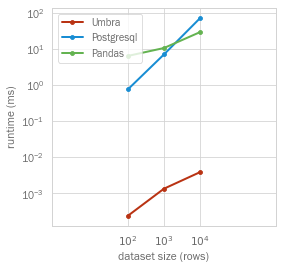

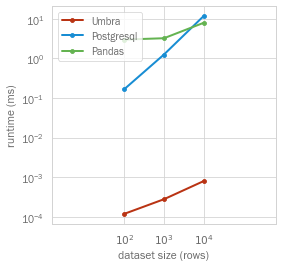

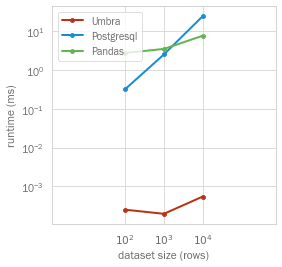

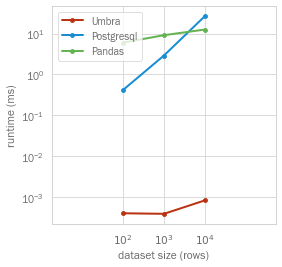

In [4]:
# Based on mlinspect benchmarks.
t1_name = "histories"
t2_name = "patients"

operations = ["Join", "Select", "Project", "GroupBy"]

umbra_times = [[] for _ in operations]
postgres_times = [[] for _ in operations]
pandas_times = [[] for _ in operations]

postgres = PostgresqlConnector(dbname="healthcare_benchmark", user="luca", password="password", port=5432,
                               host="localhost")
pandas = PandasConnector()
repetitions = 10
for i, (table1, table2) in enumerate(HEALTHCARE_DATA_PATHS):

    umbra = UmbraConnector(dbname="", user="postgres", password=" ", port=5433, host="/tmp/",
                           umbra_dir=UMBRA_DIR)

    umbra.add_csv(table_name=t2_name, path_to_csv=table2, null_symbols=["?"], delimiter=",", header=True)
    umbra.add_csv(table_name=t1_name, path_to_csv=table1, null_symbols=["?"], delimiter=",", header=True)

    postgres.add_csv(table_name=t2_name, path_to_csv=table2, null_symbols=["?"], delimiter=",", header=True)
    postgres.add_csv(table_name=t1_name, path_to_csv=table1, null_symbols=["?"], delimiter=",", header=True)

    print(f"ITERATION: {i} - for table size of: {SIZES[i]}")

    input_join = t1_name, t2_name, "ssn"
    umbra_times[0].append(umbra.benchmark_run(Join.get_sql_code(*input_join), repetitions))
    postgres_times[0].append(postgres.benchmark_run(Join.get_sql_code(*input_join), repetitions))
    pandas_times[0].append(
        pandas.benchmark_run(Join.get_pandas_code(table1, table2, "ssn"), repetitions=repetitions))

    input_sel = t1_name, "complications", ">", "5"
    umbra_times[1].append(umbra.benchmark_run(Selection.get_sql_code(*input_sel), repetitions))
    postgres_times[1].append(postgres.benchmark_run(Selection.get_sql_code(*input_sel), repetitions))
    pandas_times[1].append(
        pandas.benchmark_run(Selection.get_pandas_code(table1, "complications", ">", "5"),
                             repetitions=repetitions))

    input_project = t1_name, "smoker"
    umbra_times[2].append(umbra.benchmark_run(Projection.get_sql_code(*input_project), repetitions))
    postgres_times[2].append(postgres.benchmark_run(Projection.get_sql_code(*input_project), repetitions))
    pandas_times[2].append(
        pandas.benchmark_run(Projection.get_pandas_code(table1, "smoker"), repetitions=repetitions))

    input_project = t1_name, "smoker", "complications", "AVG"
    umbra_times[3].append(umbra.benchmark_run(GroupBy.get_sql_code(*input_project), repetitions))
    postgres_times[3].append(postgres.benchmark_run(GroupBy.get_sql_code(*input_project), repetitions))
    pandas_times[3].append(
        pandas.benchmark_run(GroupBy.get_pandas_code(table1, "smoker", "complications", "mean"),
                             repetitions=repetitions))
    # in the end we have 3 lists == [[*joins*][*selections*][*projections*]]

names = ["Umbra", "Postgresql", "Pandas"]
for i, title in enumerate(operations):
    table = [umbra_times[i], postgres_times[i], pandas_times[i]]
    plot = plot_compare(title, SIZES, all_y=table, all_y_names=names, save=True)

### The original results:
**Join**:

![](./plots/Join.png)

**GroupBy**:

![](./plots/GroupBy.png)

**Select**:

![](./plots/Select.png)

**Project**:

![](./plots/Project.png)



## Benchmark pure pipeline:

<connection object at 0x7f82f3b01e80; dsn: 'user=luca password=xxx dbname=healthcare_benchmark host=localhost port=5432', closed: 0>
ITERATION: 0 - for table size of: 100

Just translation to SQL is performed! 
-> SQL-Code placed at: mlinspect/to_sql/generated_code



Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


Executing Query in Umbra...
Done in 0.0010190999999999998!
Executing Query in Postgres...
Done in 2.2216000000000005!
Executing Query in Pandas...
Done in 19.63406639988534!
ITERATION: 1 - for table size of: 1000

Just translation to SQL is performed! 
-> SQL-Code placed at: mlinspect/to_sql/generated_code



Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


Executing Query in Umbra...
Done in 0.0012866000000000002!
Executing Query in Postgres...
Done in 17.45!
Executing Query in Pandas...
Done in 17.949244499686756!
ITERATION: 2 - for table size of: 10000

Just translation to SQL is performed! 
-> SQL-Code placed at: mlinspect/to_sql/generated_code



Killed
No user with password configured. For initial setup, connect via a domain socket:
   psql -h /tmp -U postgres


Executing Query in Umbra...
Done in 0.0046902!
Executing Query in Postgres...
Done in 175.22639999999998!
Executing Query in Pandas...
Done in 39.57875470005092!
Plotting..


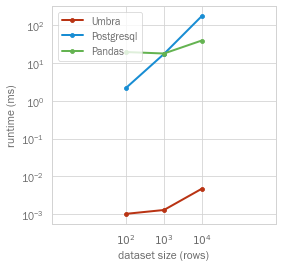

In [8]:
def get_healthcare_pipe_code_orig(path_histories, path_patients):
    setup_code = cleandoc("""
        import os
        import pandas as pd
        from mlinspect.utils import get_project_root
        """)

    test_code = cleandoc(f"""
        COUNTIES_OF_INTEREST = ['county2', 'county3']

        patients = pd.read_csv('{path_patients}', na_values='?')
        histories = pd.read_csv('{path_histories}', na_values='?')

        data = patients.merge(histories, on=['ssn'])
        complications = data.groupby('age_group') \
            .agg(mean_complications=('complications', 'mean'))
        data = data.merge(complications, on=['age_group'])
        data['label'] = data['complications'] > 1.2 * data['mean_complications']
        data = data[['smoker', 'last_name', 'county', 'num_children', 'race', 'income', 'label']]
        data = data[data['county'].isin(COUNTIES_OF_INTEREST)]
        """)

    return setup_code, test_code


def get_healthcare_SQL_str(pipeline_code, mode, materialize):
    PipelineInspector \
        .on_pipeline_from_string(pipeline_code) \
        .execute_in_sql(dbms_connector=None, mode=mode, materialize=materialize)

    setup_file = \
        pathlib.Path(r"/home/luca/Documents/Bachelorarbeit/mlinspect/mlinspect/to_sql/generated_code/create_table.sql")
    test_file = \
        pathlib.Path(r"/home/luca/Documents/Bachelorarbeit/mlinspect/mlinspect/to_sql/generated_code/pipeline.sql")

    with setup_file.open("r") as file:
        setup_code = file.read()

    with test_file.open("r") as file:
        test_code = file.read()

    return setup_code, test_code

umbra_times = []
postgres_times = []
pandas_times = []

postgres = PostgresqlConnector(dbname="healthcare_benchmark", user="luca", password="password", port=5432,
                               host="localhost")
pandas = PandasConnector()

for i, (path_to_csv_his, path_to_csv_pat) in enumerate(HEALTHCARE_DATA_PATHS):
    print(f"ITERATION: {i} - for table size of: {SIZES[i]}")

    setup_code_orig, test_code_orig = get_healthcare_pipe_code_orig(path_to_csv_his, path_to_csv_pat)

    setup_code, test_code = get_healthcare_SQL_str(setup_code_orig + "\n" + test_code_orig, mode="CTE",
                                                   materialize=False)

    ################################################################################################################
    # time Umbra:
    umbra = UmbraConnector(dbname="", user="postgres", password=" ", port=5433, host="/tmp/", umbra_dir=UMBRA_DIR)
    umbra.run(setup_code)
    umbra_times.append(umbra.benchmark_run(test_code, repetitions=BENCH_REP))

    ################################################################################################################
    # time Postgres:
    postgres.run(setup_code)
    postgres_times.append(postgres.benchmark_run(test_code, repetitions=BENCH_REP))

    ################################################################################################################
    # time Pandas:
    pandas_times.append(pandas.benchmark_run(pandas_code=test_code_orig, setup_code=setup_code_orig,
                                             repetitions=BENCH_REP))
    ################################################################################################################

print(f"Plotting..")
names = ["Umbra", "Postgresql", "Pandas"]
title = "HealthcarePurePipeComparison"
table = [umbra_times, postgres_times, pandas_times]
plot = plot_compare(title, SIZES, all_y=table, all_y_names=names, save=True)

### The original results:
**Join**:

![](./plots/HealthcarePurePipeComparison.png)

## Benchmark Inspection:

In [6]:
# Clean_up:

if DO_CLEANUP:
    [f.unlink() for f in PLOT_DIR.glob("*_.png") if f.is_file()]